Google Colab Link:
https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=SaYPv_aKId2d

In [1]:
import tensorflow as tf
import numpy as np
import time
import os

from io import BytesIO 
from tensorflow.python.lib.io import file_io

#### Load numpy data from GCS

In [2]:
f = BytesIO(file_io.read_file_to_string('gs://data-imr-unisg/np_array_files/x_train.npy', binary_mode=True))
x_train = np.load(f)
f = BytesIO(file_io.read_file_to_string('gs://data-imr-unisg/np_array_files/class_labels_trainp.npy', binary_mode=True))
y_train = np.load(f)
f = BytesIO(file_io.read_file_to_string('gs://data-imr-unisg/np_array_files/x_test.npy', binary_mode=True))
x_test = np.load(f)
f = BytesIO(file_io.read_file_to_string('gs://data-imr-unisg/np_array_files/class_labels_test.npy', binary_mode=True))
y_test = np.load(f)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 299, 299, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 710432)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                45467712  
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
__________

In [18]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver("dominique-c-a-paul")
    )
)
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    
toc = time.time()
tpu_model.fit_generator(
    train_gen(1024),
    epochs=1,
    steps_per_epoch=2,
    validation_data=(x_test, y_test),
)
tic = time.time()
print(tic-toc)

INFO:tensorflow:Querying Tensorflow master (grpc://10.240.1.2:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5338384586603007704)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15823768869043209822)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 187108137082501470)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15358661899500041051)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13247887303887475795)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(2, 299, 299, 3), dtype=tf.float32, name='batch_normalization_1_input_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_1_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 14.076910972595215 secs


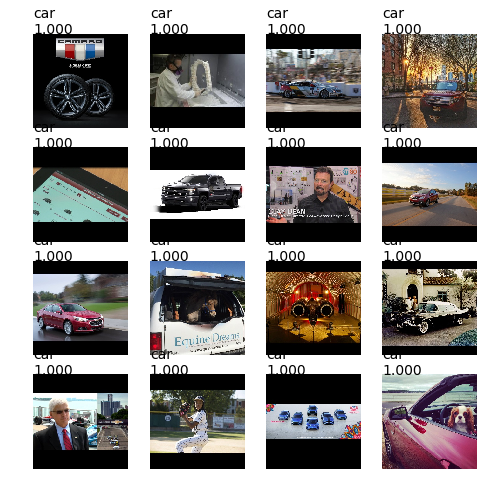

In [16]:
LABEL_NAMES = ['no_car', 'car']

cpu_model = tpu_model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test[:16]), 
                 tpu_model.predict(x_test[:16]))